## 範例重點
* 學習如何在 keras 中加入 model checkpoint
* 知道如何設定監控目標
* 比較使用最佳與非最佳參數時的 performance

In [7]:
# 從網路即時下載CIFAR10⼩圖像，數據集涵蓋50,000張32x32彩⾊色訓練圖像及10,000張測試圖像，並且標註超過10個類別
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# 查詢檔案維度資訊
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [0]:
# 資料前處理
def preproc_x(x):
    x = x.reshape((len(x), -1)) / 255.
    return x

def preproc_y(y, num_classes=10):
    from keras.utils import to_categorical

    y = to_categorical(y, num_classes)
    return y    

In [9]:
# 將資料從圖形 (RGB) 轉為向量 (Single Vector) 並進行標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)
print(f"Shape of x_train: {x_train.shape}")
print(f"Shape of x_test: {x_test.shape}")


# 將目標轉為 one-hot encoding
y_train = preproc_y(y_train, num_classes=10)
y_test = preproc_y(y_test, num_classes=10)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of x_train: (50000, 3072)
Shape of x_test: (10000, 3072)
Shape of y_train: (50000, 10)
Shape of y_test: (10000, 10)


In [0]:
from keras.layers import BatchNormalization
from keras import layers, models

def build_model(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    model = models.Sequential()
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            # 第一層
            model.add(layers.Dense(n_units, activation='relu', input_shape=(input_shape)))
            model.add(BatchNormalization())
        else:
            # 後續幾層
            model.add(layers.Dense(n_units, activation='relu'))
            model.add(BatchNormalization())

    # 最後一層
    model.add(layers.Dense(output_units, activation='softmax'))
    return model

In [0]:
# 超參數設定
learning_rate = 1e-3
epochs = 50
batch_size = 256
momentum = 0.95

In [0]:
from keras.callbacks import ModelCheckpoint

model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
                              monitor="val_loss", 
                              save_best_only=True)

In [13]:
import keras
keras.backend.clear_session()

model = build_model(input_shape=x_train.shape[1:], output_units=10, num_neurons=[512, 256, 128])
print(model.summary())

model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, nesterov=True, momentum=momentum),
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_test, y_test), 
                    shuffle=True,
                    callbacks=[model_ckpt])






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 10)          

10000/10000 [==============================] - 1s 88us/step


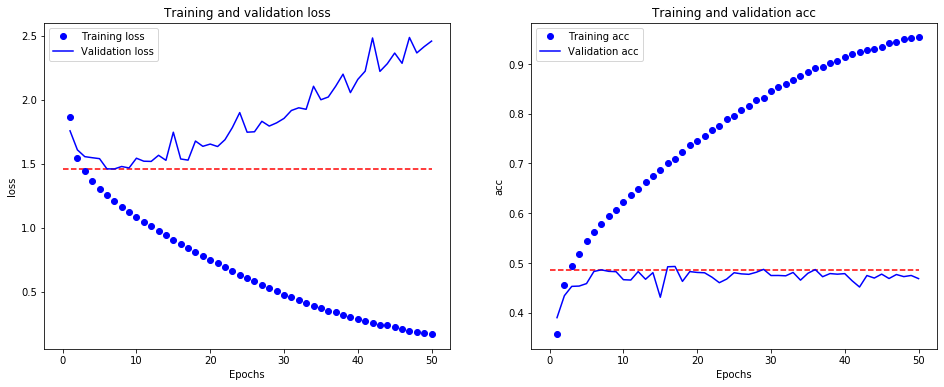

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

# Load back
mdck = {}
model = keras.models.load_model("./tmp.h5")
mdck['loadback_loss'], mdck['loadback_acc'] = model.evaluate(x_test, y_test)


# 以視覺畫方式檢視訓練過程
import matplotlib.pyplot as plt
%matplotlib inline

epochs = range(1, len(history.history['loss']) + 1)

rows, cols = 1, 2
figure, ax = plt.subplots(rows, cols, figsize=(16,6))
for i, score in enumerate(['loss', 'acc']):
    plt.subplot(1, 2, i+1)
    plt.plot(epochs, history.history[score], 'bo', label='Training '+score)
    plt.plot(epochs, history.history['val_'+score], 'b', label='Validation '+score)
    plt.hlines(y=mdck['loadback_'+score], xmin=0, xmax=len(epochs), colors='r', linestyles='--')
    plt.title('Training and validation '+score)
    plt.xlabel('Epochs')
    plt.ylabel(score)
    plt.legend()